### **Libraries**

In [18]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import joblib
from scipy.stats import yeojohnson
from sklearn.preprocessing import PowerTransformer
import numpy as np

First, we should call some variables from data cleaning process.

In [19]:
%store -r df
df = df

%store -r numeric_columns
numeric_columns = numeric_columns

%store -r cat_columns
cat_columns = cat_columns   

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27045 entries, 0 to 27378
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           27045 non-null  object 
 1   Area               27045 non-null  object 
 2   Type               27045 non-null  object 
 3   Price              27045 non-null  int64  
 4   MinDayNights       27045 non-null  int64  
 5   CountReview        27045 non-null  int64  
 6   LastDateReview     27045 non-null  object 
 7   AvgReview          27045 non-null  float64
 8   TotalHostListings  27045 non-null  int64  
 9   DayAvailability    27045 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 2.3+ MB


### **Feature Engineeringr**

In this step, we should extract year, month and day from date column.

In [ ]:
# Function to extract Year, Month, and Day from 'LastDateReview'
def extract_year_month_day(X):
    X = X.copy()
    X['LastDateReview'] = pd.to_datetime(X['LastDateReview'])
    X['Year'] = X['LastDateReview'].dt.year
    X['Month'] = X['LastDateReview'].dt.month
    X['Day'] = X['LastDateReview'].dt.day
    X.drop(columns=['LastDateReview'], inplace=True)
    return X

# Apply the transformation
df = extract_year_month_day(df)


['../../artifacts/year_extraction.pkl']

### **Handle Outlier**

In this step, we will check for outliers for features. Since our evaluation metric is `RMSE`, which is sensitive to large errors, outliers can significantly inflate the error measurement.

#### **Outlier Detection**

First, let's see the box plot to see the status of data

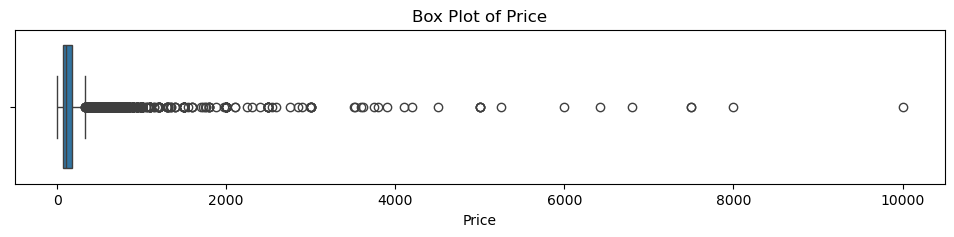

In [22]:
plt.figure(figsize = (12, 2))
sns.boxplot(x = df['Price'])
plt.title('Box Plot of Price')
plt.show()

In [23]:
print('25% of data is less than or equal' , df['Price'].quantile(0.25))
print('50% of data is less than and 50% is more than' , df['Price'].quantile(0.50))
print('75% of data is less than' , df['Price'].quantile(0.75))

25% of data is less than or equal 69.0
50% of data is less than and 50% is more than 106.0
75% of data is less than 175.0


#### **Handle Outlier**

`Removing Outliers`: When outliers are error / Dataset is very large
* IQR-based Removal
* Z-Score-based Removal
* Manual Removal
* Model-Based Removal

`Transforming Outliers`: When data is highly skewed / Outlier is not error
* Log Transformation
* Box-Cox Transformation
* Yeo-Johnson Transformation

`Capping (Winsorization)`: When just a few values are far from most of them / Outlier is not error
* Percentile-Based Capping
* IQR-Based Capping


In [24]:
def transform_distribution(df, column):
    column_name = column

    # Apply transformations
    log_transformed = np.log1p(df[column_name])  # log(1 + x), avoids log(0) issue
    sqrt_transformed = np.sqrt(df[column_name])
    yeo_transformed, _ = yeojohnson(df[column_name])

    # Check skewness
    original_skew = df[column_name].skew()
    log_skew = log_transformed.skew()
    sqrt_skew = sqrt_transformed.skew()
    yeo_skew = pd.Series(yeo_transformed).skew()

    print(f"Original Skewness: {original_skew:.4f}")
    print(f"Log Transformed Skewness: {log_skew:.4f}")
    print(f"Square Root Transformed Skewness: {sqrt_skew:.4f}")
    print(f"Yeo-Johnson Transformed Skewness: {yeo_skew:.4f}")

In [25]:
transform_distribution(df , 'Price')

Original Skewness: 16.4984
Log Transformed Skewness: 0.5118
Square Root Transformed Skewness: 3.6400
Yeo-Johnson Transformed Skewness: -0.0763


The result shows `Yeo-Johnson` works better.

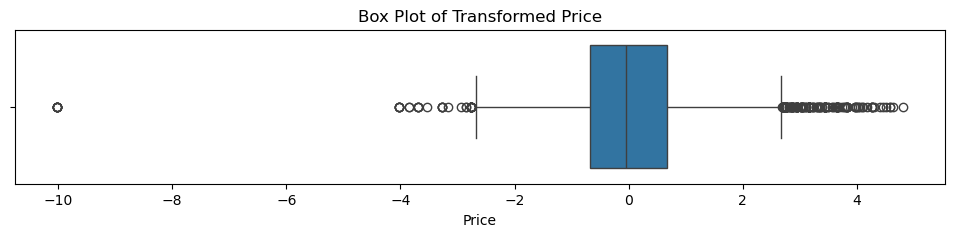

In [26]:
# Initialize transformer
yeo_transformer = PowerTransformer(method='yeo-johnson')

# Fit and transform the training price column
df['Price'] = yeo_transformer.fit_transform(df[['Price']])

# Save the transformer for later use
joblib.dump(yeo_transformer, '../../artifacts/Price_yeo_johnson_transformer.pkl')

# Plot transformed price
plt.figure(figsize=(12, 2))
sns.boxplot(x=df['Price'])
plt.title('Box Plot of Transformed Price')
plt.show()

### **Transform Numerical**

In section data understaing and descriptive analysis, we saw that some of them numerical columns need transformation. We build a function and apply Log and Sqrt Transforation to see which of them works better.

In [27]:
#MinDayNights
transform_distribution(df , numeric_columns[1])

Original Skewness: 20.5742
Log Transformed Skewness: 1.4820
Square Root Transformed Skewness: 3.8573
Yeo-Johnson Transformed Skewness: 0.2651


The result shows Yeo-Johnson works better.
<hr>

In [28]:
#CountReview
transform_distribution(df , numeric_columns[2])

Original Skewness: 3.5932
Log Transformed Skewness: 0.3472
Square Root Transformed Skewness: 1.4710
Yeo-Johnson Transformed Skewness: 0.0767


The result shows Yeo-Johnson works better.
<hr>

In [29]:
#AvgReview
transform_distribution(df , numeric_columns[3])

Original Skewness: 4.2364
Log Transformed Skewness: 0.5778
Square Root Transformed Skewness: 0.7038
Yeo-Johnson Transformed Skewness: 0.0796


The result shows Yeo-Johnson works better.
<hr>

In [30]:
#TotalHostListings
transform_distribution(df , numeric_columns[4])

Original Skewness: 7.8999
Log Transformed Skewness: 3.2953
Square Root Transformed Skewness: 5.5235
Yeo-Johnson Transformed Skewness: 0.9678


The result shows Yeo-Johnson works better.
<hr>

In [31]:
#DayAvailability
transform_distribution(df , numeric_columns[5])

Original Skewness: 0.7477
Log Transformed Skewness: -0.2235
Square Root Transformed Skewness: 0.2572
Yeo-Johnson Transformed Skewness: -0.1328


The result shows Yeo-Johnson works better.
<hr>

Since, for all, Yeo-Johnson is the best transformer, we apply it for all those features.

In [32]:
# Fit on train data
pt = PowerTransformer(method='yeo-johnson')
columns_to_transform = ['MinDayNights', 'CountReview', 'AvgReview', 'TotalHostListings', 'DayAvailability']

df[columns_to_transform] = pt.fit_transform(df[columns_to_transform])

# Save the transformer
joblib.dump(pt, '../../artifacts/Numerical_Transformer.pkl')

['../../artifacts/Numerical_Transformer.pkl']

### **Categorical Encoding**

#### **Mean-Target Encoding**

Since `Area` have many unique values (high cardinality), we use Mean Target encoding for it. the process is:
* Calculate the Mean Target (Price) for Each City in Training Data
* Replace City in the Training Set with its Corresponding Mean Price
* Apply the Same Mapping to the Test Set (Using only training means)
* Handle New Cities in the Test Set (Cities not seen in training)

In [33]:
Area_Encoder = df.groupby('Area')['Price'].mean()

# Apply encoding to training data
df['Area'] = df['Area'].map(Area_Encoder)

# Save the mean encoding mapping
joblib.dump(Area_Encoder, '../../artifacts/Area_Encoder.pkl')

['../../artifacts/Area_Encoder.pkl']

#### **One-Hot Encoding**

Now, for `Location` and `Type`, just because they don't have too many cardinality, we can use one-hot encoding.

In [34]:
# Select categorical columns to encode
categorical_cols = ['Location' , 'Type']

# Define OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit and transform only selected categorical columns
encoded_array = encoder.fit_transform(df[categorical_cols])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and merge encoded ones
df_encoded = df.drop(columns=categorical_cols).reset_index(drop=True)
df = pd.concat([df_encoded, encoded_df], axis=1)

joblib.dump(encoder, '../../artifacts/OneHot_Encoder.pkl')

['../../artifacts/OneHot_Encoder.pkl']

#### **Encoding Date**

* For `Year`: We don't encode it and later we just scale it.
* For `Month` and `Day`: We use cyclic encoding (also known as circular encoding or sine-cosine encoding)

In [ ]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data

# Apply encoding to training data
df = encode(df, 'Month', 12)
df = encode(df, 'Day', 31)

# Drop original columns
df = df.drop(columns=['Month', 'Day'])

['../../artifacts/DayMonth_Encoder.pkl']

### **CHECKPOINT**

In [36]:
%store df

Stored 'df' (DataFrame)
